<a href="https://colab.research.google.com/github/syedayazsa/transfer-learning-for-segregation/blob/master/VGG19_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORTING NECESSARY LIBRARIES**

In [0]:
from keras.layers import Input, Lambda, Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


# **LOADING AND UNZIPPING THE DATASET**

In [0]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM" -O data.zip && rm -rf /tmp/cookies.txt

--2020-05-18 13:18:15--  https://docs.google.com/uc?export=download&confirm=GZG3&id=1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM
Resolving docs.google.com (docs.google.com)... 64.233.187.101, 64.233.187.113, 64.233.187.102, ...
Connecting to docs.google.com (docs.google.com)|64.233.187.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-28-docs.googleusercontent.com/docs/securesc/km7lg0lsr2t0ufdlgdauq8b0rb08dkig/demcm1o27vgret9d468gsdro7fnbp78h/1589807850000/14211000813324722452/09617084780846533095Z/1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM?e=download [following]
--2020-05-18 13:18:16--  https://doc-0o-28-docs.googleusercontent.com/docs/securesc/km7lg0lsr2t0ufdlgdauq8b0rb08dkig/demcm1o27vgret9d468gsdro7fnbp78h/1589807850000/14211000813324722452/09617084780846533095Z/1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM?e=download
Resolving doc-0o-28-docs.googleusercontent.com (doc-0o-28-docs.googleusercontent.com)... 108.177.125.132, 2404:6800:4008:c01::84
Connectin

# **SPECIFIYING PATHS TO DIRECTORY**

In [0]:
base_path = '/content/split_dataset'

folders = glob('/content/split_dataset/train/*')
print(folders)

['/content/split_dataset/train/automatic_rifles', '/content/split_dataset/train/boots', '/content/split_dataset/train/pistol_revolver', '/content/split_dataset/train/band-aid', '/content/split_dataset/train/syringes', '/content/split_dataset/train/knives', '/content/split_dataset/train/bottles', '/content/split_dataset/train/bullet_shells']


In [0]:
IMAGE_SIZE = [224, 224]

train_path = '/content/split_dataset/train'
valid_path = '/content/split_dataset/validation'

# **PREPARING THE PRE-TRAINED VGG**

In [0]:
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [0]:
x = Flatten()(vgg.output)
x = Dense(2048, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# **CREATING THE VGG MODEL**

In [0]:
model_vgg = Model(inputs=vgg.input, outputs=prediction)
model_vgg.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [0]:
model_vgg.compile(
  loss='categorical_crossentropy',
  optimizer= 'adam',
  metrics=['accuracy']
)

# **USING IMAGE AUGMENTATION**

In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    rescale = 1./255,
    fill_mode = 'nearest')

validation_datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    rescale = 1./255,
    fill_mode = 'nearest')

training_set = train_datagen.flow_from_directory('/content/split_dataset/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

validation_set = validation_datagen.flow_from_directory('/content/split_dataset/validation',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 6481 images belonging to 8 classes.
Found 1625 images belonging to 8 classes.


In [0]:
history_vgg = model_vgg.fit_generator(
  training_set,
  validation_data=validation_set,
  epochs=5,
  verbose = 1,
  steps_per_epoch=640,
  validation_steps=120
  )

Epoch 1/5


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


640/640 [==============================] - 351s 548ms/step - loss: 0.5203 - accuracy: 0.8380 - val_loss: 1.3315 - val_accuracy: 0.6307
Epoch 2/5
640/640 [==============================] - 346s 541ms/step - loss: 0.3295 - accuracy: 0.8991 - val_loss: 0.3496 - val_accuracy: 0.8332
Epoch 3/5
640/640 [==============================] - 346s 540ms/step - loss: 0.2875 - accuracy: 0.9134 - val_loss: 0.2036 - val_accuracy: 0.8555
Epoch 4/5
640/640 [==============================] - 346s 541ms/step - loss: 0.2653 - accuracy: 0.9167 - val_loss: 0.1619 - val_accuracy: 0.8785
Epoch 5/5
640/640 [==============================] - 345s 539ms/step - loss: 0.2506 - accuracy: 0.9252 - val_loss: 0.2502 - val_accuracy: 0.8748


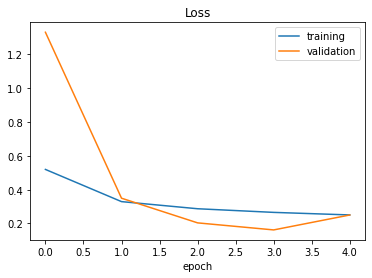

In [0]:
plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])

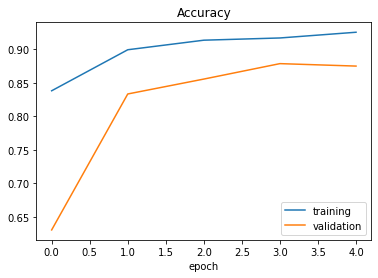

In [0]:
plt.plot(history_vgg.history['accuracy'])
plt.plot(history_vgg.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!ls gdrive

'My Drive'


In [0]:
model_vgg.save('/content/gdrive/My Drive/Model/vgg.h5')

In [0]:
!unzip '/content/data.zip'

Streaming output truncated to the last 5000 lines.
  inflating: split_dataset/train/bottles/img (677).jpg  
  inflating: split_dataset/train/bottles/img (678).jpg  
  inflating: split_dataset/train/bottles/img (679).jpg  
  inflating: split_dataset/train/bottles/img (68).jpg  
  inflating: split_dataset/train/bottles/img (680).jpg  
  inflating: split_dataset/train/bottles/img (681).jpg  
  inflating: split_dataset/train/bottles/img (682).jpg  
  inflating: split_dataset/train/bottles/img (683).jpg  
  inflating: split_dataset/train/bottles/img (684).jpg  
  inflating: split_dataset/train/bottles/img (685).jpg  
  inflating: split_dataset/train/bottles/img (686).jpg  
  inflating: split_dataset/train/bottles/img (687).jpg  
  inflating: split_dataset/train/bottles/img (688).jpg  
  inflating: split_dataset/train/bottles/img (689).jpg  
  inflating: split_dataset/train/bottles/img (69).jpg  
  inflating: split_dataset/train/bottles/img (690).jpg  
  inflating: split_dataset/train/bottle